<a href="https://colab.research.google.com/github/fernandodelaiglesia/cajondesastre/blob/master/PhaseEstimation_ProjectQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Preliminary notes

This notebook is created assuming that the QPE gate is still in the develop branch, and therefore you need to clone the ProjectQ github repo to be able to use it.

If you use this notebook after QPE is included in the python package you don't need to clone the repo and add the path to the sys.path, but just to install projectq with:


```
!pip install projectq
```






In [1]:
! git clone https://github.com/ProjectQ-Framework/ProjectQ.git

Cloning into 'ProjectQ'...
remote: Enumerating objects: 1893, done.
remote: Total 1893 (delta 0), reused 0 (delta 0), pack-reused 1893
Receiving objects: 100% (1893/1893), 839.10 KiB | 14.47 MiB/s, done.
Resolving deltas: 100% (1394/1394), done.


In [0]:
import sys
sys.path.append('/content/ProjectQ/')

Import the required libs

In [0]:
from projectq import MainEngine
from projectq.backends import Simulator
from projectq.ops import Ph, All, Measure, StatePreparation, H, X, CNOT
from projectq.ops import QPE

import math
import numpy as np


# Simple usage of Quantum Phase Estimation for a system with just 1 qubit (system_qubits)
The phase estimated is the expected because of the definition on the Unitary as a phase gate with pahse 0.125

In [0]:
eng = MainEngine()

n_qpe_ancillas = 3
qpe_ancillas = eng.allocate_qureg(n_qpe_ancillas)
system_qubits = eng.allocate_qureg(1)
  
angle = math.pi*2.*0.125
U = Ph(angle)

# Apply Quantum Phase Estimation
QPE(U) | (qpe_ancillas, system_qubits)

All(Measure) | qpe_ancillas
# Compute the phase from the ancilla measurement
#(https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)
phasebinlist = [int(q) for q in qpe_ancillas]
phase_in_bin = ''.join(str(j) for j in phasebinlist)
phase_int = int(phase_in_bin,2)

phase = phase_int / (2 ** n_qpe_ancillas)
print (phase)
  
All(Measure) | system_qubits
eng.flush()

(Note: This is the (slow) Python simulator.)
0.375


# Elaborated usage of Quantum Phase Estimation for a system with 2 qubit (system_qubits) and a elaborated Unitary Operation
The state is not just an eigenstate of the unitary operation but it is a superposition of two of them

The phase estimated should be 0.0 for the state |+> = 1/sqrt(2) (|00> + |10>) and 0.5 for the state |-> = 1/sqrt(2) (|00> - |10>).

|+> and |-> are eigenstates for the unitary operator X·I

The original state is a superposition of these two |+> and |->: |Phi> = sin(Pi/3) |+> + cos(Pi/3) |->


In [0]:
from projectq.ops import BasicGate

# Definition of the elaborated unitary operation
class unitary_operation(BasicGate):
  def __init__(self):
    BasicGate.__init__(self)
  
  @property
  def matrix(self):
     return np.matrix([[0, 1, 0, 0],
                       [1, 0, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0, 1, 0]])

unitary_op = unitary_operation()


In [0]:
eng2 = MainEngine()

n_qpe_ancillas = 1
system_qubits = eng2.allocate_qureg(2)
qpe_ancillas = eng2.allocate_qureg(n_qpe_ancillas)


# Create the state
amplitude00 = (np.sqrt(3) + 1.)/(np.sqrt(2) * 2.)
amplitude10 = (np.sqrt(3) - 1.)/(np.sqrt(2) * 2.)
StatePreparation([amplitude00, amplitude10, 0., 0.]) | system_qubits

unit = unitary_op

# Apply Quantum Phase Estimation
QPE(unit) | (qpe_ancillas, system_qubits)
All(Measure) | qpe_ancillas
fasebinlist = [int(q) for q in qpe_ancillas]
fasebin = ''.join(str(j) for j in fasebinlist)
faseint = int(fasebin, 2)
phase = faseint / (2. ** (len(qpe_ancillas)))
results = phase

H | system_qubits[0]

if np.allclose(phase, .0, rtol=1e-1):
  results_plus = phase
  All(Measure) | system_qubits
  autovector_result = [int(q) for q in system_qubits]
  print (autovector_result, phase)
elif np.allclose(phase, .5, rtol=1e-1):
  results_minus = phase
  All(Measure) | system_qubits
  autovector_result = [int(q) for q in system_qubits]
  print (autovector_result, phase)

eng2.flush()


(Note: This is the (slow) Python simulator.)
[1, 0] 0.5


# Usage of parameter depending functions as unitary


We create the Unitary function so that when it is exponentiated for the QPE algorithm, the result is equal to set the parameter to the exponentiation factor. In the example below the parameter is the variable "*time*" and the function is:


In [0]:
def two_qubit_gate(system_q, time):
  CNOT | (system_q[0], system_q[1])
  Ph(2.0*math.pi*(time * 0.125)) | system_q[1]
  CNOT | (system_q[0], system_q[1])

In [0]:
eng3 = MainEngine()

n_qpe_ancillas = 3
qpe_ancillas = eng3.allocate_qureg(n_qpe_ancillas)
system_qubits = eng3.allocate_qureg(2)

X | system_qubits[0]

# Apply Quantum Phase Estimation
QPE(two_qubit_gate) | (qpe_ancillas, system_qubits)
All(Measure) | qpe_ancillas
phasebinlist = [int(q) for q in qpe_ancillas]
phase_in_bin = ''.join(str(j) for j in phasebinlist)
phase_int = int(phase_in_bin,2)

phase = phase_int / (2 ** n_qpe_ancillas)
print (phase)

All(Measure) | system_qubits
eng3.flush()

(Note: This is the (slow) Python simulator.)
0.125


# Statistical results
The phase estimation algorithm provides the estimation with some probability. That means that the algoritm will success with a certain probability (see the references)

(Note: This is the (slow) Python simulator.)


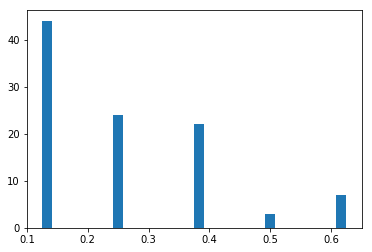

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

eng = MainEngine()

angle = math.pi*2.*0.125
U = Ph(angle)


results = np.array([])
for i in range(100):
  autovector = eng.allocate_qureg(1)
  ancillas = eng.allocate_qureg(3)
  # Apply Quantum Phase Estimation
  QPE(U) | (ancillas, autovector)
  All(Measure) | ancillas
  fasebinlist = [int(q) for q in ancillas]
  fasebin = ''.join(str(j) for j in fasebinlist)
  faseint = int(fasebin, 2)
  phase = faseint / (2. ** (len(ancillas)))
  results = np.append(results, phase)
  All(Measure) | autovector
  eng.flush()


x=plt.hist(results, bins=30)

